In [26]:
%matplotlib inline

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from scipy.signal import find_peaks
import pandas as pd
from skimage.color import rgb2gray
from skimage.exposure import histogram, cumulative_distribution
from skimage.util import img_as_ubyte, invert, img_as_float
from skimage.feature import peak_local_max
from skimage.segmentation import watershed, find_boundaries, relabel_sequential, clear_border
from skimage import measure
from skimage import morphology
from skimage import filters
import math
from collections import defaultdict
import plotly
import plotly.express as px
import plotly.graph_objects as go

from sklearn import feature_extraction
from sklearn.cluster import spectral_clustering

import seaborn as sns

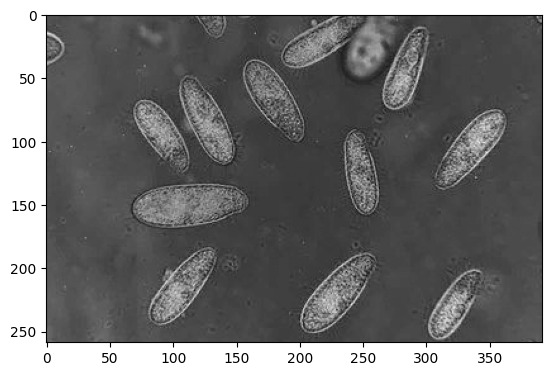

In [12]:
TEM_Image = plt.imread('IM0.jpg')
TEM_Image = invert(img_as_ubyte(rgb2gray(TEM_Image)))
plt.imshow(TEM_Image, cmap='gray')

In [13]:
hi_ins, bins = histogram(TEM_Image) #получение гистаграммы
cdf, cdf_bins = cumulative_distribution(TEM_Image)
hi_ins = np.array(hi_ins/hi_ins.max()) #нормирование по самому интенсивному пику
xi_max, peaks_propeties = find_peaks(hi_ins, height=0,  prominence=0, width=4, distance=1) #нахождение пиков и их характеристик
df_peaks = pd.DataFrame(peaks_propeties) #таблица характеристик пиков
df_peaks.insert(0,'x of peaks', xi_max) #добавление столбца с координатой пика x
df_peaks['widths'] = round(df_peaks['widths']).astype(int)
df_peaks['left_ips'] = round(df_peaks['left_ips']).astype(int)
df_peaks['right_ips'] = round(df_peaks['right_ips']).astype(int)
df_peaks['true_left_bases'] = round(((df_peaks['left_bases']-(1-(df_peaks['peak_heights']/df_peaks['prominences']))*(df_peaks['left_ips']-df_peaks['x of peaks']))+df_peaks['left_bases'])/2).astype(int) #поправка

In [14]:
df_peaks


,x of peaks,peak_heights,prominences,left_bases,right_bases,widths,width_heights,left_ips,right_ips,true_left_bases
0,39,1.000000,1.000000,4,131,11,0.500000,33,44,4
1,75,0.051993,0.004714,73,131,5,0.049636,74,78,68


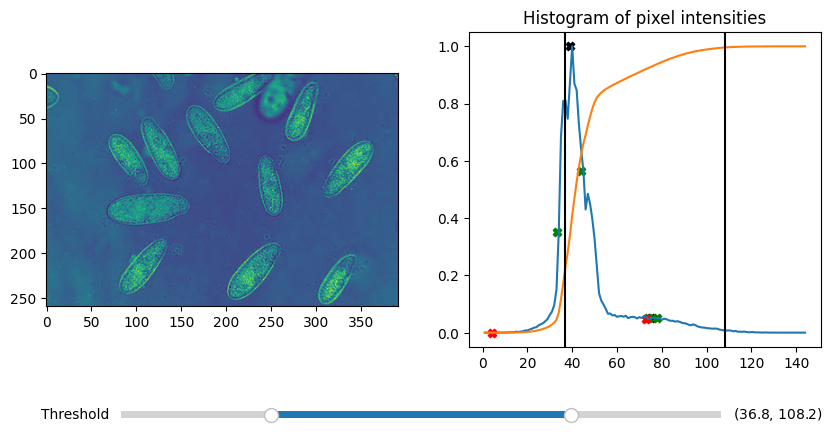

In [15]:
from matplotlib.widgets import RangeSlider

img = TEM_Image

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(bottom=0.25)

im = axs[0].imshow(img)
axs[1].plot(bins, hi_ins)
axs[1].plot(cdf_bins, cdf)
axs[1].scatter(xi_max, df_peaks['peak_heights'],c='black', marker='X')
axs[1].scatter(df_peaks['left_ips'], hi_ins[df_peaks['left_ips']],c='green', marker='X')
axs[1].scatter(df_peaks['right_ips'], hi_ins[df_peaks['right_ips']],c='green', marker='X')
axs[1].scatter(df_peaks['left_bases'], hi_ins[df_peaks['left_bases']],c='red', marker='X')
axs[1].set_title('Histogram of pixel intensities')

# Create the RangeSlider
slider_ax = fig.add_axes([0.20, 0.1, 0.60, 0.03])
slider = RangeSlider(slider_ax, "Threshold", img.min(), img.max())

# Create the Vertical lines on the histogram
lower_limit_line = axs[1].axvline(slider.val[0], color='k')
upper_limit_line = axs[1].axvline(slider.val[1], color='k')


def update(val):
    # The val passed to a callback by the RangeSlider will
    # be a tuple of (min, max)

    # Update the image's colormap
    im.norm.vmin = val[0]
    im.norm.vmax = val[1]

    # Update the position of the vertical lines
    lower_limit_line.set_xdata([val[0], val[0]])
    upper_limit_line.set_xdata([val[1], val[1]])

    # Redraw the figure to ensure it updates
    fig.canvas.draw_idle()


slider.on_changed(update)
plt.show()

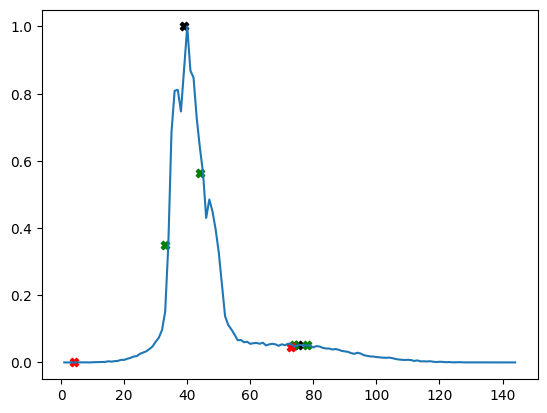

In [16]:
fig = plt.figure()
plt.plot(bins, hi_ins)
plt.scatter(xi_max, df_peaks['peak_heights'],c='black', marker='X')
plt.scatter(df_peaks['left_ips'], hi_ins[df_peaks['left_ips']],c='green', marker='X')
plt.scatter(df_peaks['right_ips'], hi_ins[df_peaks['right_ips']],c='green', marker='X')
plt.scatter(df_peaks['left_bases'], hi_ins[df_peaks['left_bases']],c='red', marker='X')

In [17]:
back_board=df_peaks['true_left_bases'][1] #левая граница основания второго пика
back = TEM_Image < back_board
TEM_Image_zb = TEM_Image.copy()
TEM_Image_zb[back]=0 #мы до этой границы зануляем, делаем фон полностью черным

#удаляем сначала маленькиие отверстия, потом маленькие объекты, использованное изображение должно быть типом bool, поэтому TEM_Image_zb > 0
TEM_Image_hz = morphology.remove_small_objects(morphology.remove_small_holes(TEM_Image_zb > 0))
TEM_Image_hz = morphology.convex_hull_object(TEM_Image_hz) #превращаем клетки в выпуклые фигуры
print(df_peaks['true_left_bases'][1])
print(df_peaks['left_bases'][1])

68
73


(np.float64(-0.5), np.float64(391.5), np.float64(258.5), np.float64(-0.5))

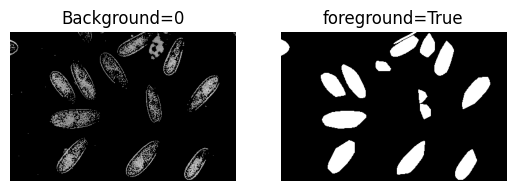

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(TEM_Image_zb, cmap='gray')
ax[0].set_title('Background=0')
ax[0].axis('off')
ax[1].imshow(TEM_Image_hz, cmap='gray')
ax[1].set_title('foreground=True')
ax[1].axis('off')

In [19]:
labels=measure.label(TEM_Image_hz) #определяем отдельно стоящие объекты и присваиваем им номер
regions=measure.regionprops(labels) #определяем свойства объектов

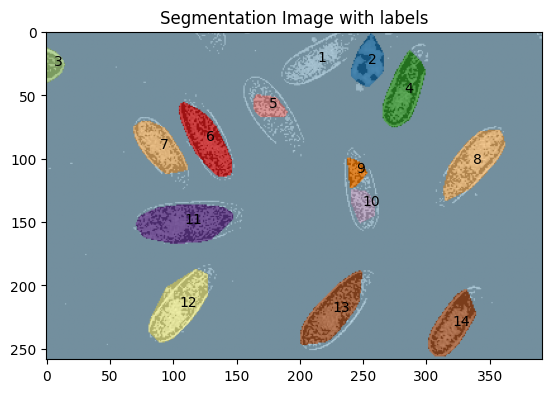

In [20]:
fig, ax = plt.subplots()
ax.imshow(TEM_Image_zb, cmap='gray')
ax.imshow(labels, cmap='Paired', alpha=0.7)
ax.set_title('Segmentation Image with labels')
for props in regions:
    y0, x0 = props.centroid #координаты центра объекта
    ax.text(x0, y0, props.label) #пишем номер

In [21]:
df_regions = pd.DataFrame (measure.regionprops_table (labels, intensity_image=TEM_Image_zb, #аналогичная функция regionprops только для таблицы, тут надо указать какие свойства добавить в столбцы
properties=(
    'label',
    'solidity', 
    'extent', 
    'eccentricity',
    'equivalent_diameter_area',
    'feret_diameter_max',
    'axis_major_length',
    'axis_minor_length',
    'perimeter',
    'area')))

In [22]:
df_regions

,label,solidity,extent,eccentricity,equivalent_diameter_area,feret_diameter_max,axis_major_length,axis_minor_length,perimeter,area
0,1,0.885004,0.529767,0.882091,38.081752,59.548300,56.955827,26.830739,227.178716,1139.0
1,2,0.972222,0.673077,0.792065,30.591356,42.426407,39.586471,24.165056,106.811183,735.0
2,3,0.966667,0.690476,0.810298,19.215605,28.071338,26.202508,15.355131,70.284271,290.0
3,4,0.970138,0.610897,0.906534,40.164593,62.817195,62.167024,26.242702,152.610173,1267.0
4,5,0.968992,0.771605,0.792665,21.850969,29.966648,28.309754,17.259255,74.284271,375.0
5,6,0.967669,0.519370,0.934565,40.480357,69.339743,67.978546,24.186329,160.509668,1287.0
6,7,0.966994,0.600221,0.870964,37.150931,54.817880,53.183415,26.131527,134.953319,1084.0
7,8,0.971336,0.543367,0.910066,43.570634,70.604532,67.990109,28.179363,165.580736,1491.0
8,9,0.928839,0.645833,0.760726,17.769733,24.515301,23.075403,14.977611,64.284271,248.0
9,10,0.959391,0.736842,0.748393,21.938198,28.160256,27.288957,18.099552,75.698485,378.0


In [27]:
fig = px.imshow(TEM_Image_zb, binary_string=True)
fig.update_traces(hoverinfo='skip')  # hover is only for label info

properties = ['area']

# For each label, add a filled scatter trace for its contour,
# and display the properties of the label in the hover of this trace.
for index in range(0, labels.max()):
    label_i = regions[index].label
    contour = measure.find_contours(labels == label_i, 0.5)[0]
    y, x = contour.T
    hoverinfo = ''
    for k in range(len(properties)):
        hoverinfo += f'<b>{properties[k]}: {getattr(regions[index], properties[k]):.4f}</b><br>'
    fig.add_trace(
        go.Scatter(
            x=x,
            y=y,
            name=str(label_i),
            mode='lines',
            fill='toself',
            showlegend=False,
            hovertemplate=hoverinfo,
            hoveron='points+fills',
        )
    )

plotly.io.show(fig)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

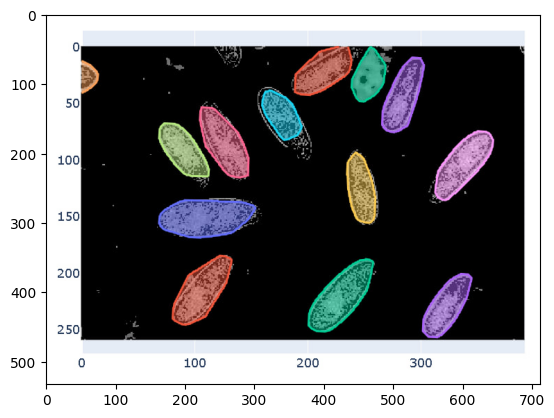